# Bar charts of violations by state, year, contaminant code(s)

In [1]:
import os
import numpy as np
import pandas as pd
import MySQLdb

%matplotlib inline

data_dir = '../../../data'

## Connect to MySQL cloud db
1. slack @fpaupier for db_user and password
2.1  Download Google SDK: 
        Linux: https://cloud.google.com/sdk/docs/quickstart-linux
        Windows: https://cloud.google.com/sdk/docs/quickstart-windows
        macOS: https://cloud.google.com/sdk/docs/quickstart-macos
2.2 from command line `gcloud auth login`
2.3 from command line `gcloud init`
3.1 install https://cloud.google.com/sql/docs/mysql/quickstart-proxy-test#install-proxy
3.2 run sql cloud proxy ./cloud_sql_proxy -instances=safe-water-235819:us-east1:safe-water-db=tcp:3306
4. pip install MySQLdb

In [2]:
# Read un and pwd from local file that is not deployed!
# first line un, second line pwd
# Alternatively just enter un, pwd in cell below but don't check it in!
my_settings = []
with open(os.path.join(data_dir, 'my_settings.txt')) as f:
    for line in f:
        my_settings.append(line)
un = my_settings[0].rstrip('\n')
pwd = my_settings[1].rstrip('\n')

In [3]:
db_user= un
password= pwd
db = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user=db_user,         # your username
                     passwd=password,  # your password
                     port=3306,
                     db = 'safe_water')        # name of the data base

## Fetch data into DataFrames

In [4]:
cmd = "select PWSID, PWS_TYPE_CODE, STATE_CODE from WATER_SYSTEM"
water_sys = pd.read_sql(cmd, db)
water_sys.head()

,PWSID,PWS_TYPE_CODE,STATE_CODE
0,010106001,CWS,CT
1,010109001,NTNCWS,None
2,010109005,CWS,CT
3,010307001,CWS,MA
4,010502001,TNCWS,RI


In [5]:
# get a zero padded string for contaminant code
# e.g. 400 to '0400'
def convert_code_to_string(row):
    return str(row['CONTAMINANT_CODE']).zfill(4)

In [6]:
# uncomment 2nd line if you want only health based violations
cmd = "select distinct PWSID, CONTAMINANT_CODE, COMPL_PER_BEGIN_DATE from VIOLATION " #\
#    + "where IS_HEALTH_BASED_IND = 'Y'"

viol = pd.read_sql(cmd, db)

# this is a workaround, ideally CONTAMINANT_CODE should be a string
viol.loc[:, 'CONTAMINANT_CODE_STR'] = viol.apply(convert_code_to_string, axis=1)
viol.head()

,PWSID,CONTAMINANT_CODE,COMPL_PER_BEGIN_DATE,CONTAMINANT_CODE_STR
0,MS0730004,4006,2010-07-01,4006
1,NC0319125,2043,2002-01-01,2043
2,NY1316696,2982,2016-01-01,2982
3,WV3305539,2456,2012-01-01,2456
4,FL3590699,3000,1984-10-01,3000


## Join violations to dictionary of contaminants, to get names

In [13]:
contaminant_codes = pd.read_csv(os.path.join(data_dir, 'sdwis/contaminant-codes.csv'), sep=',', \
                               dtype={'CODE': np.str})
contaminant_codes = contaminant_codes.rename(index=str, columns={"NAME": "CONTAMINANT"})
contaminant_codes[contaminant_codes['CONTAMINANT'] == "LEAD"]


,CODE,CONTAMINANT,SCIENTIFIC_NAME,TYPE_CODE
39,1030,LEAD,NaN,IOC


In [14]:
viol = pd.merge(viol, contaminant_codes, left_on='CONTAMINANT_CODE_STR', right_on='CODE', how='left')
viol = viol[['PWSID', 'CONTAMINANT_CODE', 'CONTAMINANT', 'COMPL_PER_BEGIN_DATE']].drop_duplicates()
viol.head()

,PWSID,CONTAMINANT_CODE,CONTAMINANT,COMPL_PER_BEGIN_DATE
0,MS0730004,4006,COMBINED URANIUM,2010-07-01
1,NC0319125,2043,ALDICARB SULFOXIDE,2002-01-01
2,NY1316696,2982,CARBON TETRACHLORIDE,2016-01-01
3,WV3305539,2456,TOTAL HALOACETIC ACIDS (HAA5),2012-01-01
4,FL3590699,3000,COLIFORM (PRE-TCR),1984-10-01


In [15]:
def get_year_for_violation(row):
    if row['COMPL_PER_BEGIN_DATE'] is not None:
        return row['COMPL_PER_BEGIN_DATE'].year
    else:
        return 0

In [16]:
viol.loc[:, 'VIOLATION_YEAR'] = viol.apply(get_year_for_violation, axis=1)

In [17]:
water_sys_viol = pd.merge(water_sys, viol, on='PWSID')
water_sys_viol.head()

,PWSID,PWS_TYPE_CODE,STATE_CODE,CONTAMINANT_CODE,CONTAMINANT,COMPL_PER_BEGIN_DATE,VIOLATION_YEAR
0,010106001,CWS,CT,2050,ATRAZINE,2016-01-01,2016
1,010106001,CWS,CT,2010,BHC-GAMMA,2016-01-01,2016
2,010106001,CWS,CT,2036,OXAMYL,2016-01-01,2016
3,010106001,CWS,CT,2035,DI(2-ETHYLHEXYL) ADIPATE,2016-01-01,2016
4,010106001,CWS,CT,2959,CHLORDANE,2016-01-01,2016


In [18]:
# df: water system violation dataframe
# state: two letter code
# contaminant_codes: enter empty array for all
def get_num_violations(df, state, min_year, max_year, contaminant_codes=[]):
    if len(contaminant_codes) > 0:
        return df[(df['STATE_CODE']==state) & \
                  (df['VIOLATION_YEAR'] >= min_year) & \
                  (df['VIOLATION_YEAR'] <= max_year) & \
                  (df['CONTAMINANT_CODE'].isin(contaminant_codes))
                 ].groupby(['CONTAMINANT', 'VIOLATION_YEAR'])
    else:
        return df[(df['STATE_CODE']==state) & \
                  (df['VIOLATION_YEAR'] >= min_year) & \
                  (df['VIOLATION_YEAR'] <= max_year)
                 ].groupby(['CONTAMINANT', 'VIOLATION_YEAR'])


## Plot number of violations on a bar chart

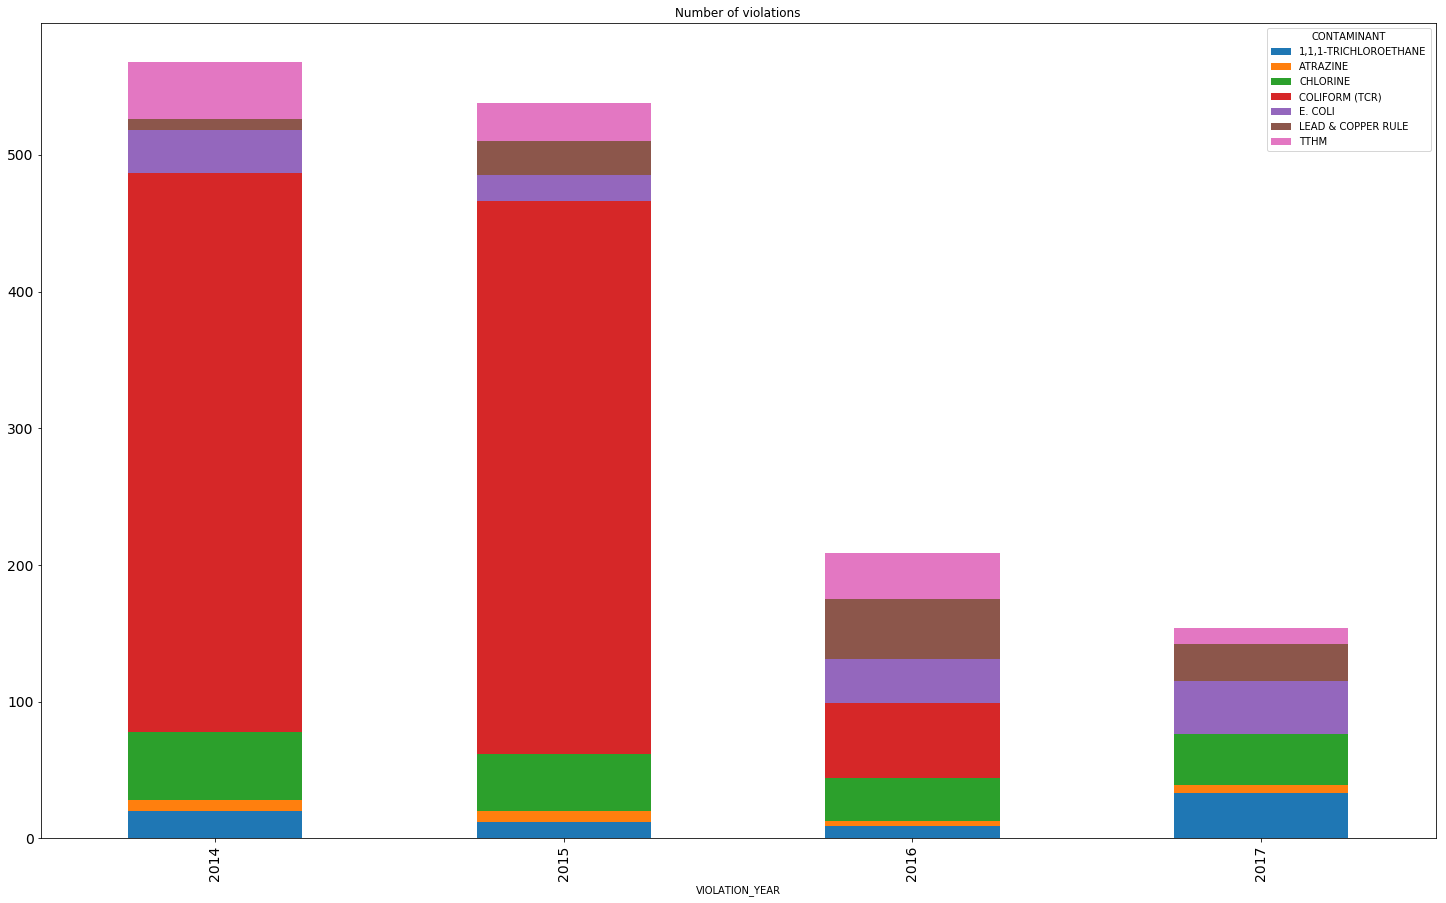

In [24]:
# Violations in the state between 2008 and 2018
contaminant_codes = [999, 1030, 2050, 2950, 2981, 3014, 3100, 5000] # pass this optionally to filter by contaminant

# 
'''
lead 1030
coliform 3000
fecal coliform 3030
ecoli 3014
coliform(tcr) 3100
chlorine 999
tthm 2950
atrazine 2050
1,1,1-trichloroethane 2981
'''

df = get_num_violations(water_sys_viol, 'VT', 2014, 2017, contaminant_codes)
s1 = df.size()

if len(s1.index) > 0:
    df3 = s1.unstack()
    df3.T.plot.bar(stacked=True, figsize = (25,15), title='Number of violations', fontsize=14)
else:
    print ('No data to chart')